#### 분류 성능평가지표 개념 제대로 이해하기
- 머신러닝 교재 3장 내용

- 분류(classification) 성능평가지표
    * Accuracy : 양성-양성, 음성-음성 => 불균형 데이터일 경우 신뢰성이 없음
    * Precision : 예측 양성으로 했고 정답도 양성인 것
    * Recall : 정답 양성인데 예측 양성
    * F1-Score
    * ConfusionMatrix 
    * ROC-AUC => 의료분야 / 2진분류

#### boston_house 데이터셋 활용 집값 예측 모델
- 데이터셋 : boston.csv
- 구현프레임워크 : Pytorch

- [1] 모듈 로딩 및 데이터 준비

In [37]:
# 모듈 로딩
import numpy as np
import torch                                # 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn                       # 인공신경망 관련 모듈
import torch.nn.functional as F             # 손실, 거래 등 함수 관련 모듈
import torch.optim as optimizer             # 최적화 기법 관련 모듈
from torchmetrics.regression import R2Score # 성능지표 관련 모듈 - 추가 설치
from torchinfo import summary               # 모델 정보 관련 모듈 - 추가 설치

import matplotlib.pyplot as plt
import pandas as pd                         # 데이터 파일 분석 관련 모듈
from sklearn.model_selection import train_test_split

In [38]:
# 모델의 가중치 및 절편 값 고정 설정
torch.manual_seed(1)

# 저장 및 실행 위치 설정
DEVICE='cuda' if torch.cuda.is_available() else 'cpu'

print(f'DEVICE => {DEVICE}')

DEVICE => cpu


In [39]:
# 데이터 로딩 : CSV => DataFrame
DATA_FILE=pd.read_csv('../data/boston.csv')
bostonDF=pd.DataFrame(DATA_FILE)

bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [40]:
bostonDF.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


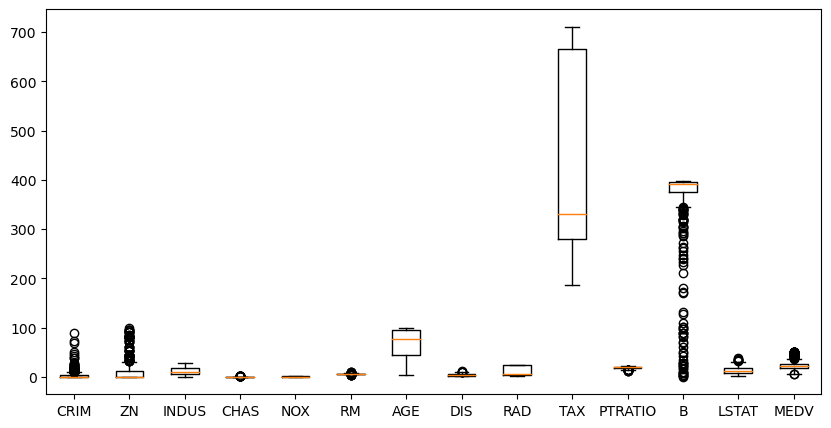

In [41]:
plt.figure(figsize = (10, 5))
plt.boxplot(bostonDF.iloc[:, :14])
plt.xticks(np.arange(1,15), bostonDF.columns[:14])
plt.show()

[2] 모델 준비
- 학습방법 : 지도학습 > 회귀
- 알고리즘 : 선형관계 >> 선형모델 nn.Linear 

In [42]:
# 모델 설계
# 입력층의 입력값/피쳐 => sepal.length, sepal.width, petal.length 3개
# 출력층의 출력값/타겟 => petal.width 1개
# 입력층 : 입력 피쳐3, 출력 입력층에 존재하는 퍼셉트론 개수 10, AF ReLU
# 은닉층 : 입력 10, 출력 은닉층에 존재하는 퍼셉트론 개수 5, AF ReLU
# 출력층 : 입력 5, 출력 타겟/라벨 개수 1 , AF None
model=nn.Sequential(nn.Linear(13,50),
                       nn.ReLU(),
                       nn.Linear(50,30),
                       nn.ReLU(),
                       nn.Linear(30,1))
                   

In [43]:
# 모델 구조 확인
print(model)
summary(model, input_size=(10000, 13))

Sequential(
  (0): Linear(in_features=13, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=30, bias=True)
  (3): ReLU()
  (4): Linear(in_features=30, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [10000, 1]                --
├─Linear: 1-1                            [10000, 50]               700
├─ReLU: 1-2                              [10000, 50]               --
├─Linear: 1-3                            [10000, 30]               1,530
├─ReLU: 1-4                              [10000, 30]               --
├─Linear: 1-5                            [10000, 1]                31
Total params: 2,261
Trainable params: 2,261
Non-trainable params: 0
Total mult-adds (M): 22.61
Input size (MB): 0.52
Forward/backward pass size (MB): 6.48
Params size (MB): 0.01
Estimated Total Size (MB): 7.01

In [44]:
# 가중치와 절편 확인
for name, param in model.named_parameters():
    print(f'[{name}] {param}\n')

[0.weight] Parameter containing:
tensor([[ 0.1429, -0.1224, -0.0538,  0.1302, -0.2611,  0.1663, -0.0571,  0.1411,
          0.0386, -0.0340,  0.0769,  0.0137,  0.1013],
        [-0.1081, -0.0202, -0.0250,  0.0402, -0.0011,  0.2425,  0.0863, -0.1033,
         -0.1675, -0.0465, -0.1196, -0.0889,  0.0133],
        [ 0.1653,  0.1507, -0.2711,  0.1719,  0.0775,  0.2631,  0.1831, -0.2527,
         -0.2637, -0.1338,  0.2435, -0.0462,  0.1187],
        [-0.1289,  0.2721, -0.1173,  0.2080,  0.0033, -0.1461,  0.1426, -0.1472,
          0.0816, -0.0801, -0.0304, -0.2666, -0.1322],
        [ 0.1505, -0.0674,  0.2763,  0.2223, -0.0130, -0.1851,  0.1689,  0.0861,
         -0.1793,  0.1802,  0.1684,  0.2460, -0.1555],
        [-0.0457, -0.0054,  0.0405, -0.2105, -0.1968,  0.1509, -0.0650,  0.1355,
          0.0158,  0.0911,  0.0610,  0.1008,  0.1375],
        [-0.2569,  0.1396, -0.1950, -0.2093,  0.0169, -0.0473,  0.1629, -0.1606,
         -0.2466,  0.2018, -0.0411,  0.1560,  0.0892],
        [-0.208

[3] 최적화 인스턴스 준비

In [45]:
# 모델의 가중치와 절편을 최적화 => 인스턴스에 전달
adam_optim=optimizer.Adam(model.parameters(), lr=0.1)

[4] 학습 => 개발자가 구현

- [4-1] 데이터셋 Tensor화 진행 : 데이터준비 시 진행하거나 학습 전 진행

In [46]:
# 피쳐와 타겟 분리
featureDF=bostonDF[bostonDF.columns[:-1]]
targetDF=bostonDF[['MEDV']]
print(featureDF.shape, targetDF.shape)

(506, 13) (506, 1)


In [47]:
# Train & Test
X_train, X_test, y_train, y_test=train_test_split(featureDF, targetDF, test_size=0.2, random_state=5)

# Train & Valid
X_train, X_val, y_train, y_val=train_test_split(X_train, y_train, test_size=0.2, random_state=5)

print(f'TRAIN {X_train.shape}, TEST {X_test.shape}, VAL {X_val.shape}')
print(f'TRAIN {y_train.shape}, TEST {y_test.shape}, VAL {y_val.shape}')

TRAIN (323, 13), TEST (102, 13), VAL (81, 13)
TRAIN (323, 1), TEST (102, 1), VAL (81, 1)


In [48]:
# 스케일링
from sklearn.preprocessing import RobustScaler

scaler=RobustScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [49]:
X_val_scaled = scaler.transform(X_val) 
X_test_scaled = scaler.transform(X_test)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

- [4-2] 학습진행
    * 학습횟수 결정 => 에포크 설정
    * 배치크기 결정
    * 배치개수 계산

In [50]:
EPOCH=100                                                     # 처음~끝까지 공부하는 횟수
BATCH_SIZE=12                                                    # 1에포크에서 한 번 학습 할 분량 크기
BATCH_CNT=X_train.shape[0]//BATCH_SIZE                              # 1에포크에서 총 학습 횟수이자 업데이트 횟수

print(f'EPOCH: {EPOCH}, DP_SIZE: {BATCH_SIZE}, DP_CNT: {BATCH_CNT}')

EPOCH: 100, DP_SIZE: 12, DP_CNT: 26


In [51]:
# 테스트/검증 함수
# => 가중치, 절편 업데이트 X, 최적화 미진행
# => 현재 가중치와 절편값으로 테스트 진행
# 모델 학습 함수
def testing(testDF, targetDF, kind='Val'):
    # Tensor화
    testTS=torch.FloatTensor(testDF.values).to(DEVICE)
    targetTS=torch.FloatTensor(targetDF.values).to(DEVICE)
    
    with torch.no_grad(): # 가중치 및 절편 업데이트 진행 X
        # (1) 학습진행 : forward
        pre_y=model(testTS)

        # (2) 오차계산 : 손실함수
        loss=F.mse_loss(pre_y, targetTS)
        
        # (3) 성능평가 - R2
        r2=R2Score()(pre_y, targetTS)

        # (4) 학습결과 출력 및 저장
        print(f'[{kind}] LOSS : {loss}, R2 : {r2}')
    
    return loss, r2

In [52]:
# 모델 학습 함수
def training(featureTS, targetTS, valTS, valTargetTS):
    # [[],[]] <= [train, val]
    loss_history=[[],[]]
    r2_history=[[],[]]
    
    for epoch in range(EPOCH):
        # 배치 손실 저장 변수
        ds_loss, ds_r2=0, 0

        # 배치크기 만큼 학습 진행
        for i in range(BATCH_CNT):
            start=i*BATCH_SIZE
            end=start + BATCH_SIZE
            print(start, end)
            # DP_SIZE 크기만큼만 데이터 추출해서 Tensor화 진행
            DSX_train=torch.FloatTensor(X_train[start:end].values).to(DEVICE)
            DSy_train=torch.FloatTensor(y_train[start:end].values).to(DEVICE)

            # print(DSX_train.shape, DSX_train.device, DSX_train.dtype)
            # print(DSy_train.shape, DSy_train.device, DSy_train.dtype)

            # (1) 학습진행 : forward
            pre_y=model(DSX_train)
            # print(f'pre_y.shape : {pre_y.shape}')

            # (2) 오차계산 : 손실함수
            loss=F.mse_loss(pre_y, DSy_train)
            ds_loss += loss.item()
            ds_r2 += R2Score()(pre_y, DSy_train).item()

            # (3) 최적화 : 가중치, 절편 업데이트 backward
            adam_optim.zero_grad()
            loss.backward()
            adam_optim.step()
            
        # (4) 검증 : 모델이 제대로 만들어 지는지 검사용
        val_loss, val_r2=testing(valTS, valTargetTS)
        loss_history[1].append(val_loss.item())
        r2_history[1].append(val_r2.item())

        # 에포크 단위 손실과 성능지표
        loss_history[0].append(ds_loss/BATCH_CNT)
        r2_history[0].append(ds_r2/BATCH_CNT)

        # (5) 학습결과 출력 및 저장
        print(f'[{epoch}/{EPOCH}]\n-TRAIN LOSS : {loss_history[0][-1]} R2 : {r2_history[0][-1]}')
        print(f'-VALID LOSS : {loss_history[1][-1]} R2 : {r2_history[1][-1]}')
        
    return loss_history, r2_history

In [53]:
# 모델 학습 진행
loss, r2 = training(X_train_scaled_df, y_train, X_val_scaled_df, y_val)

0 12
12 24
24 36
36 48
48 60
60 72
72 84
84 96
96 108
108 120
120 132
132 144
144 156
156 168
168 180
180 192
192 204
204 216
216 228
228 240
240 252
252 264
264 276
276 288
288 300
300 312
[Val] LOSS : 687.3229370117188, R2 : -6.917331218719482
[0/100]
-TRAIN LOSS : 9085.12189263564 R2 : -175.66853629167264
-VALID LOSS : 687.3229370117188 R2 : -6.917331218719482
0 12
12 24
24 36
36 48
48 60
60 72
72 84
84 96
96 108
108 120
120 132
132 144
144 156
156 168
168 180
180 192
192 204
204 216
216 228
228 240
240 252
252 264
264 276
276 288
288 300
300 312
[Val] LOSS : 683.1221923828125, R2 : -6.868942737579346
[1/100]
-TRAIN LOSS : 76.1280308503371 R2 : -0.16251895748651946
-VALID LOSS : 683.1221923828125 R2 : -6.868942737579346
0 12
12 24
24 36
36 48
48 60
60 72
72 84
84 96
96 108
108 120
120 132
132 144
144 156
156 168
168 180
180 192
192 204
204 216
216 228
228 240
240 252
252 264
264 276
276 288
288 300
300 312
[Val] LOSS : 664.6489868164062, R2 : -6.656148433685303
[2/100]
-TRAIN LOSS :

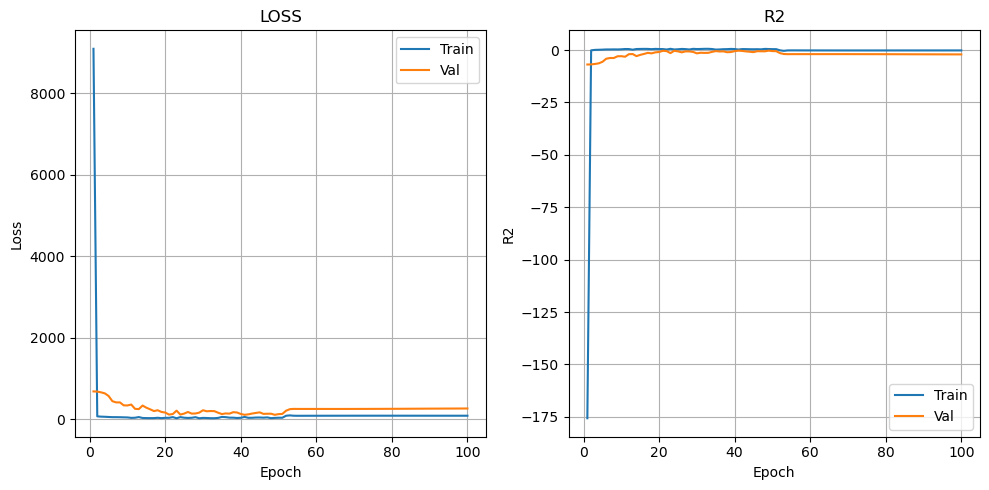

In [54]:
# 학습 후 loss 시각화

THRESHOLD=100
fg, axes=plt.subplots(1,2,figsize=(10,5))
axes[0].plot(range(1,THRESHOLD+1),loss[0][:THRESHOLD], label='Train')
axes[0].plot(range(1,THRESHOLD+1),loss[1][:THRESHOLD], label='Val')
axes[0].set_title('LOSS')
axes[0].grid()
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(range(1,THRESHOLD+1),r2[0][:THRESHOLD], label='Train')
axes[1].plot(range(1,THRESHOLD+1),r2[1][:THRESHOLD], label='Val')
axes[1].set_title('R2')
axes[1].grid()
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('R2')
axes[1].legend()

plt.tight_layout()
plt.show()